## Batch experiments same as in Leonardo's paper

    1. Pre-train UID ELM on 50 users
    
    2. Repeat for each batch of 5 users:
        3. Take batch of 5 users, LOO single signature for validation
        4. Train on 50+5 users
        5. Predict on LOO single signature of 5 users

    6. Repeat on true/fake classification ELM

Use ELM implementation in `HPELM @ GPU` for speed

In [1]:
from hpelm import HPELM

In [2]:
import os
import pickle
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
%matplotlib inline

In [3]:
data_folder = "/Users/akusok/wrkdir/research-signatures-data/MCYTDB"
overlap = '50p'
samples = 10000000 // 30

data_file = "/Users/akusok/wrkdir/research-signatures-data/MCYTD_overlap{}_n200.pkl".format(overlap)

# 

In [4]:
with open(data_file, 'rb') as f:
    X0 = pickle.load(f)
    
X0 = X0.reset_index(drop=True)

Make a `users` list of user batches, sizes `[50, 5, 5, 5, 5, 5]`

In [5]:
uu = list(X0.uid.unique())
random.shuffle(uu)
users = [uu[:50]]
users.extend([uu[i:i+5] for i in range(50,75,5)])

Make a data loader that gives us required batch, optionally setting aside 1 file per user

In [37]:
def load_batch(j, loo=False):
    """Load batch `j` of `users` list, as Numpy array.
    
    loo (bool, default=False): whether to return single LOO file per user separately.
    """    
    data = X0[X0.uid.isin(users[j])]
    
    if loo:
        # get LOO split
        t = data.loc[:, 'uid':'fid']
        t = t.sample(frac=1.0, replace=False)
        fid_loo = t.groupby('uid').first()['fid']

        data_loo = data[data.fid.isin(fid_loo)]
        data = data[~data.fid.isin(fid_loo)]
        Y_loo = data_loo.loc[:, 'sig_true'].to_numpy()
        U_loo = data_loo.loc[:, 'uid']
        Z_loo = data_loo.loc[:, '0':'1023'].to_numpy()

    Y = data.loc[:, 'sig_true'].to_numpy()
    Z = data.loc[:, '0':'1023'].to_numpy()
    
    zm = Z.mean()
    zs = Z.std().clip(min=0.5)
    Z = (Z - zm) / zs
    Z = Z.clip(min=-5, max=5)

    if loo:
        Z_loo = (Z_loo - zm) / zs
        Z_loo = Z_loo.clip(min=-5, max=5)
        return Z, Y, Z_loo, Y_loo, U_loo
        
    return Z, Y

In [38]:
x,y,xv,yv, uv = load_batch(2, loo=True)

#  

## pre-train

In [131]:
%%time
model = HPELM(1024, 1, norm=10**0.8, batch=10000)
#model.add_neurons(1, 'lin', W=np.zeros((1024,1)), B=np.ones(1,))
model.add_neurons(10000-1024, 'tanh')
model.add_neurons(1024, 'lin')

CPU times: user 347 ms, sys: 12.4 ms, total: 359 ms
Wall time: 361 ms


In [132]:
Xp, Yp = load_batch(0, loo=False)

In [133]:
Xp = Xp[::3].copy()
Yp = Yp[::3].copy()

In [134]:
%time model.add_data(Xp, Yp)

processing batch 1/10, eta 0:02:26
processing batch 2/10, eta 0:02:17
processing batch 3/10, eta 0:01:55
processing batch 4/10, eta 0:01:36
processing batch 5/10, eta 0:01:18
processing batch 6/10, eta 0:01:02
processing batch 7/10, eta 0:00:45
processing batch 8/10, eta 0:00:30
processing batch 9/10, eta 0:00:14
processing batch 10/10, eta 0:00:00
CPU times: user 7min 5s, sys: 25.7 s, total: 7min 31s
Wall time: 2min 28s


#  

## Supervised prediction

In [135]:
res = []

for k in range(1,6):
    print(k)
    x, y, xv, yv, uv = load_batch(k, loo=True)
    
    model.add_data(x, y)
    model.nnet.solve()
    
    yh1 = model.predict(xv)
    yv1 = yv[:,None]
    res_k = pd.DataFrame(np.hstack((yv1, yh1)), index=uv).groupby('uid').mean()
    res.append(res_k)

1
processing batch 1/3, eta 0:00:28
processing batch 2/3, eta 0:00:13
processing batch 3/3, eta 0:00:00
2
processing batch 1/3, eta 0:00:30
processing batch 2/3, eta 0:00:14
processing batch 3/3, eta 0:00:00
3
processing batch 1/3, eta 0:00:28
processing batch 2/3, eta 0:00:13
processing batch 3/3, eta 0:00:00
4
processing batch 1/3, eta 0:00:29
processing batch 2/3, eta 0:00:15
processing batch 3/3, eta 0:00:00
5
processing batch 1/3, eta 0:00:27
processing batch 2/3, eta 0:00:14
processing batch 3/3, eta 0:00:00


#### read results

In [136]:
R = pd.concat(res, axis=0)
R

,0,1
uid,,
37,0.0,0.497648
46,1.0,0.600573
67,0.0,0.520491
72,0.0,0.569078
74,1.0,0.538123
17,1.0,0.630476
18,0.0,0.572745
36,0.0,0.362570
99,0.0,0.394479


In [137]:
pt = R[0]
ph = R[1]

In [138]:
from sklearn.metrics import accuracy_score

In [139]:
accuracy_score(pt>0.5, ph>0.5)

0.76

In [107]:
pass

0.76

In [92]:
pass

0.76

In [65]:
pass

0.72

### ROC curve

In [140]:
from sklearn.metrics import roc_curve, roc_auc_score

In [141]:
fpr, tpr, thresholds = roc_curve(pt, ph)

In [142]:
auc = roc_auc_score(pt, ph)

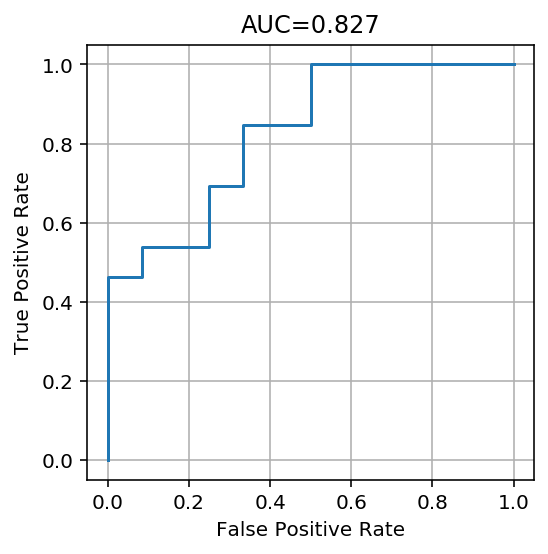

In [143]:
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.grid('minor')
plt.title("AUC={:.3f}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("binary-roc.pdf", bbox_inches='tight')
plt.show()

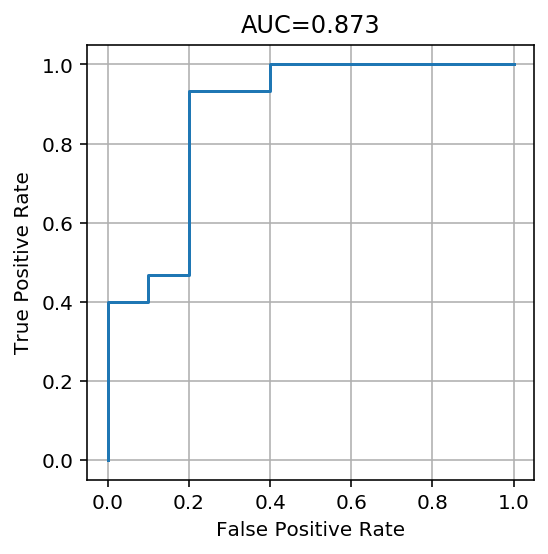

In [111]:
pass

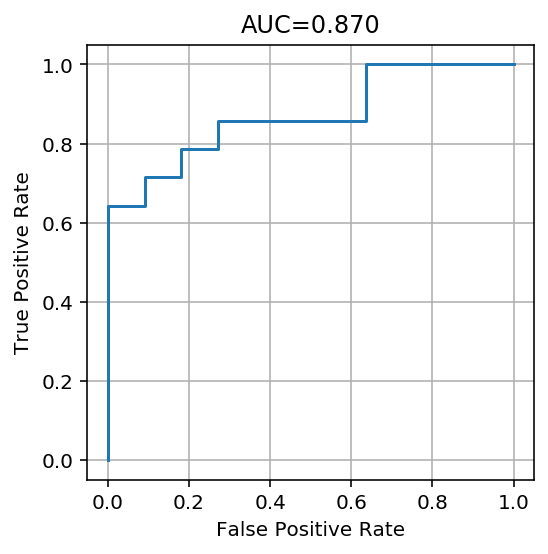

In [98]:
pass

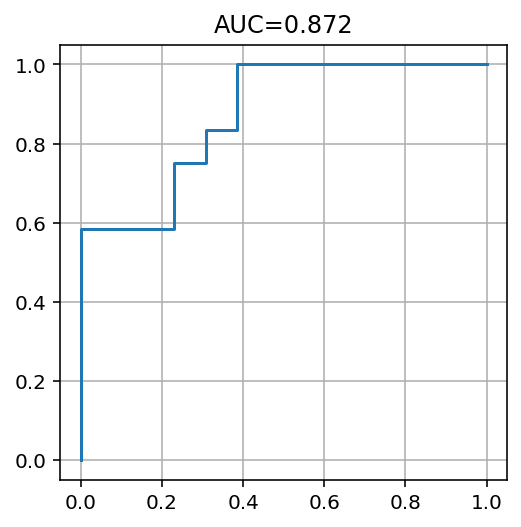

In [80]:
pass

In [ ]:
R.mean(axis=0)

In [ ]:
pass